# Sign Language Image Classfication

In [1]:
# necesary imports
import os
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing

In [2]:
# Load the dataset
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
print(train_df.shape, test_df.shape)

(27455, 785) (7172, 785)


In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [5]:
print(sorted(train_df['label'].unique()))
print(sorted(test_df['label'].unique()))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 200]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [7]:
train_df = train_df[(train_df['label'] >= 0) & (train_df['label'] <= 24)]

print(sorted(train_df['label'].unique()))
print(sorted(test_df['label'].unique()))
print(train_df.shape, test_df.shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
(27454, 785) (7172, 785)


In [8]:
# Remap the labels so that the range is 0-23
original_labels = [i for i in range(25) if i!=9]
label_map = {orig: new for new, orig in enumerate(original_labels)}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

print(sorted(train_df['label'].unique()))
print(sorted(test_df['label'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [9]:
import string

label_names = [c for c in string.ascii_lowercase if c not in ['j','z']]
print(label_names)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [10]:
# Convert labels and images to np arrays (and normalize the images)
train_labels = train_df['label'].to_numpy()
test_labels = test_df['label'].to_numpy()
train_images = (train_df.drop(columns=['label']).to_numpy())/255.0
test_images = (test_df.drop(columns=['label']).to_numpy())/255.0
print(np.min(train_images), np.max(train_images))

0.0 1.0


In [15]:
from tensorflow.keras.utils import to_categorical

train_labels_encoded = to_categorical(train_labels, num_classes = 24)
test_labels_encoded = to_categorical(test_labels, num_classes = 24)

train_labels_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

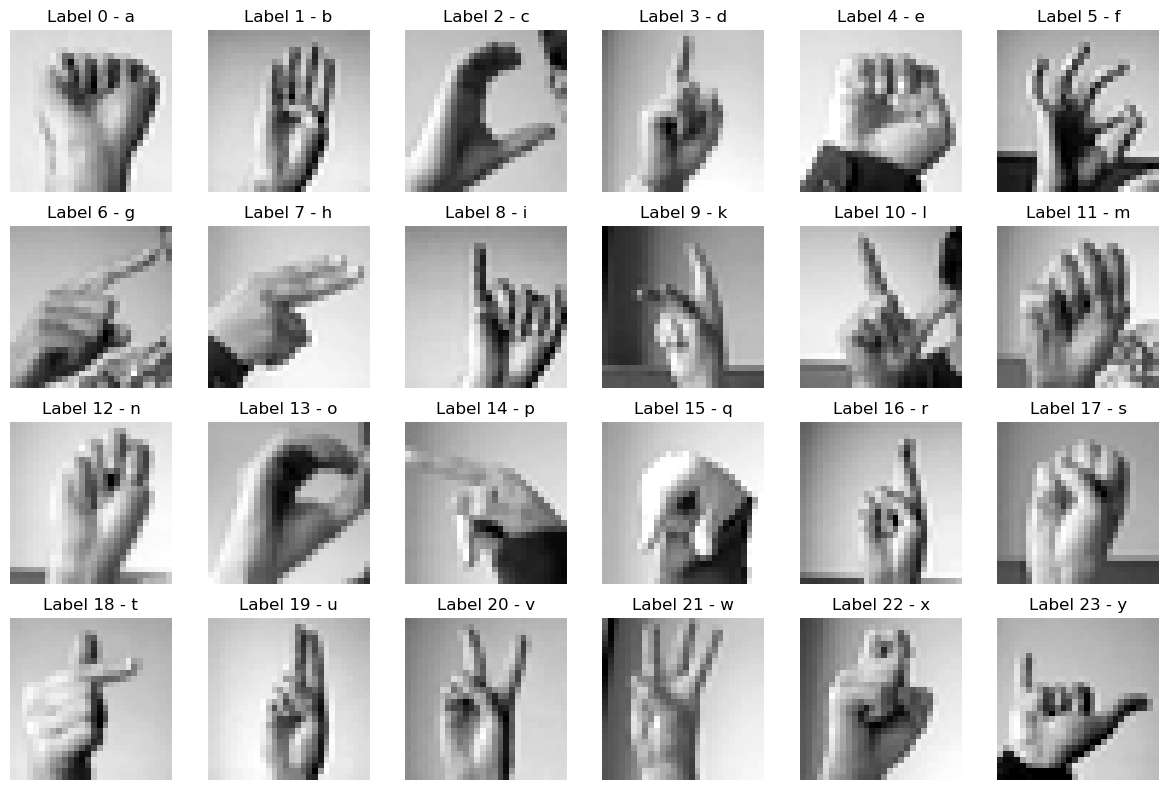

In [17]:
plt.figure(figsize=(12,8))
for i in range(24):
    idx = np.where(train_labels == i)[0][0]
    img = train_images[idx].reshape(28,28)
    plt.subplot(4,6,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label {i} - {label_names[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, InputLayer, Dropout
from tensorflow.keras.activations import relu, softmax, swish
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Model 1: With Batch Normalization
